In [1]:
import openreview
from collections import Counter, defaultdict as dd
import numpy as np
import pandas as pd
import qgrid
from pprint import pprint
import datetime
import pickle
import re 
import time
import jellyfish
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def all_papers():
    client = openreview.Client(baseurl='https://openreview.net')
    paper_iterator = openreview.tools.iterget_notes(client, invitation='ICLR.cc/2019/Conference/-/Blind_Submission')
    return list(paper_iterator)

In [3]:
def ratings_and_confidence():
    client = openreview.Client(baseurl='https://openreview.net')
    review_iterator = openreview.tools.iterget_notes(client, invitation='ICLR.cc/2019/Conference/-/Paper.*/Official_Review')
    ratings = dd(list)
    confidence = dd(list)
    for review in review_iterator:
        ratings[review.forum].append(int(re.findall(pattern='\d+', string=review.content['rating'])[0]))
        confidence[review.forum].append(int(re.findall(pattern='\d+', string=review.content['confidence'])[0]))
    return ratings, confidence

In [4]:
papers = all_papers()
ratings, confidence = ratings_and_confidence()

In [5]:
def add_ratings(papers, ratings, confidence):
    for ix in range(len(papers)):
        forum = papers[ix].forum
        papers[ix].ratings = ratings.get(forum, [])
        papers[ix].confidence = confidence.get(forum, [])

In [6]:
add_ratings(papers, ratings, confidence)

In [7]:
def get_keywords(papers):
    return list(set([word.strip().lower() for p in papers for word in p.content['keywords']]))

def get_similarity(keywords):
    sim = dict()
    N = len(keywords)
    for i in range(N-1):
        for j in range(i+1, N):
            topic1 = keywords[i]
            topic2 = keywords[j]
            dist = len(set(topic1).intersection(set(topic2)))/len(set(max([topic1, topic2], key=lambda v: len(v))))
            if topic1 != topic2 and dist >= 0.70:
                dist = jellyfish.levenshtein_distance(topic1, topic2)
                sim[topic1, topic2] = dist
    return sim

def get_top_matches(sim):
    matches = dd(list)
    for pair in sim:
        if sim[pair] == 1:
            matches[pair[0]].append(pair[1])
            matches[pair[1]].append(pair[0])
    return matches    

In [8]:
keywords = get_keywords(papers)
start = time.time()
sim = get_similarity(keywords) # this may take several minutes 
finish = time.time()
print('Similarity computed in {:.2f} sec'.format(finish - start))

Similarity computed in 208.53 sec


In [9]:
matches = get_top_matches(sim)

In [10]:
def get_clusters(matches):
    clusters = dict()
    for topic in matches:
        values = matches[topic]
        clusters[topic] = topic
        for v in values:
            if len(matches.get(v, [])) > len(values) or \
            (len(matches.get(v, [])) == len(values) and topic > v):
                clusters[topic] = v
    return clusters

In [11]:
clusters = get_clusters(matches)

In [12]:
def get_df(papers, clusters):
    rows = []
    for paper in papers:
        topic = paper.content['keywords'][0] if len(paper.content['keywords']) else ''
        cluster = clusters.get(topic.lower(), topic.lower() if topic else None)
        row = dict(tldr = paper.content.get('TL;DR', ''),
                  ratings = getattr(paper, 'ratings', []),
                  confidence = getattr(paper, 'confidence', []),
                  title = paper.content['title'],
                  avg_rating = np.mean(getattr(paper, 'ratings', [])),
                  avg_confidence = np.mean(getattr(paper, 'confidence', [])),
                  topic = cluster,
                  url = "https://openreview.net/forum?id=" + paper.forum
                  )
        rows.append(row)
    df = pd.DataFrame(rows)
    df.index.name = 'Index'
    df = df.iloc[:, [4,1,0,6,5,3,2,7]]
    return df 

In [13]:
df = get_df(papers, clusters)

In [14]:
all_ratings = df['ratings'].agg(sum)
all_confidence = df['confidence'].agg(sum)
avg_rating = np.mean(all_ratings)
avg_confidence = np.mean(all_confidence)
import datetime
print('Statistics for', datetime.datetime.now().date())
print('Average rating: {:.1f}'.format(avg_rating))
print('Average confidence: {:.1f}'.format(avg_confidence))
print('Total number of reviews:', len(all_ratings))
print('Total number of papers:', df.shape[0])
c = sorted(Counter(all_ratings).items())
for k, v in c:
    print('Score {} appeared in {} reviews'.format(k, v))

Statistics for 2018-11-19
Average rating: 5.2
Average confidence: 3.8
Total number of reviews: 4576
Total number of papers: 1512
Score 1 appeared in 17 reviews
Score 2 appeared in 92 reviews
Score 3 appeared in 430 reviews
Score 4 appeared in 1037 reviews
Score 5 appeared in 1189 reviews
Score 6 appeared in 938 reviews
Score 7 appeared in 614 reviews
Score 8 appeared in 196 reviews
Score 9 appeared in 56 reviews
Score 10 appeared in 7 reviews


In [15]:
sns.set(rc={'figure.figsize':(20,8.27)}, font_scale=2)
def plot_heatmap(df):
    all_ratings = df['ratings'].agg(sum)
    all_confidence = df['confidence'].agg(sum)
    N, M = len(set(all_confidence)), len(set(all_ratings))
    heat = np.zeros((N, M))
    c = Counter(zip(all_confidence, all_ratings))
    for key in c:
        row, col = key
        heat[row-1, col-1] = c[key]
    normalized_heat = heat/np.linalg.norm(heat, axis=0)
    
    ax = sns.heatmap(normalized_heat, xticklabels=list(range(1,11)), yticklabels=list(range(1,6)), linewidths=.5)
    ax.set_title('Confidence in Reviews. \nNormalized for each review score.')
    ax.set_xlabel('Review Score')
    ax.set_ylabel('Confidence')
    plt.show()
    
def plot_frequencies(df):
    topics = Counter(df.topic).most_common(50)
    topics = list(filter(lambda v: v[0], topics))
    freq = pd.DataFrame(topics, columns = ['topic', 'occurences'])
    bars = sns.barplot(x='topic', y='occurences', data=freq)
    bars.set_title('Frequency of Popular Topics.')
    xlabels = bars.set_xticklabels(bars.get_xticklabels(), rotation=90)
    plt.show()

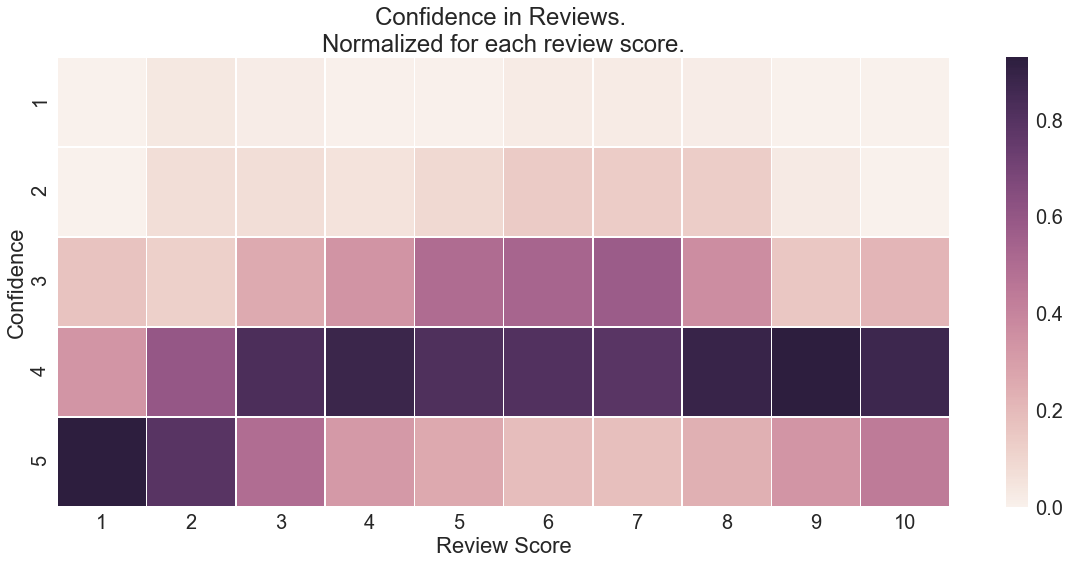

In [16]:
plot_heatmap(df)

C:\Program Files\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


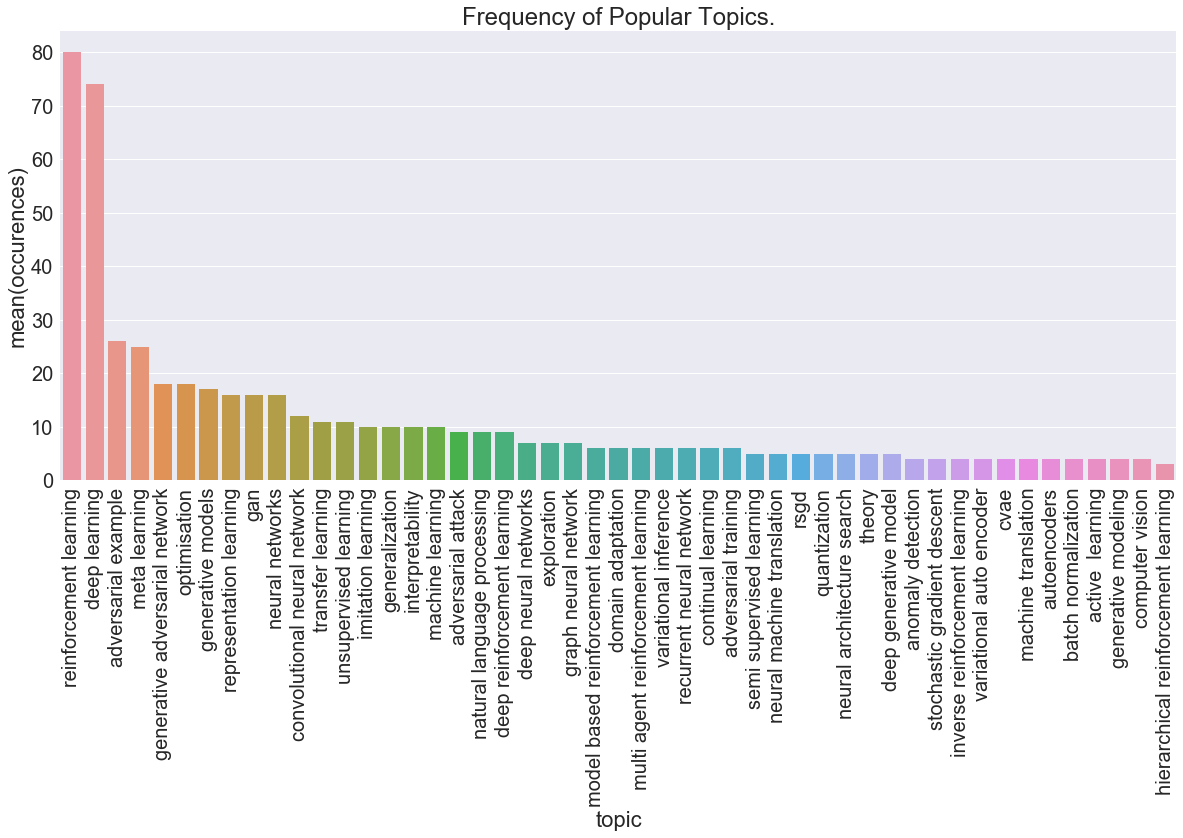

In [17]:
plot_frequencies(df)

In [18]:
col_defs = {
    name: {
        'width': 50
    } for name in ['Index', 'confidence', 'ratings']
}
col_defs['title'] = {'width': 500}
col_defs['avg_rating'] = {'width': 100}
col_defs['tldr'] = {'width': 1000}
col_defs['url'] = {'width': 300}
col_defs['topic'] = {'width': 200}
grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100}
qgrid.show_grid(df, column_definitions=col_defs, grid_options = grid_options, precision=1)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…